<a href="https://colab.research.google.com/github/amyDing629/AI-ML-DL/blob/main/CSC420A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Note: The code in this file utilizes and modifies some of the code in CSC420H TUT6.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os
from torchsummary import summary
import sys
import tarfile
import cv2
from IPython.display import display, Image
import numpy as np
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda, nn
from torch.utils.data import DataLoader
from timeit import default_timer as timer
from PIL import UnidentifiedImageError, Image
import pandas as pd

In [ ]:
num_classes = 10
def extract_gz_file(filename):
  """
  Extract tar.gz file. Return directories in the extracted folder.
  """
  # remove .tar.gz
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  
  if os.path.isdir(root):
    print('File %s already present - Skipping extraction' % filename)
  else:
    tar = tarfile.open('/content/drive/My Drive/'+filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  # get sub folder names
  data_folders = []
  for d in sorted(os.listdir(root)):
    directory = os.path.join(root, d)
    if os.path.isdir(directory):
      data_folders.append(directory)

  return data_folders

test_filename = 'notMNIST_small.tar.gz'
data_folders = extract_gz_file(test_filename)

  

File notMNIST_small.tar.gz already present - Skipping extraction


In [ ]:
mainfolder_name = ['test', 'train', 'valid']
subfolder_name = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
def initiate_folders():
  """
  Create test, train, valid main folders and A~J subfolders inside each main folder.
  """
  path = "/content/notMNIST_small/"
  for mainfolder in mainfolder_name:
    try:
       os.mkdir(path + mainfolder)
       print('path created: ' + path + mainfolder)
    except:
       # skip if path exists
       print('path already exists: ' + path + mainfolder)
  for mainfolder in mainfolder_name:
    for subfolder in subfolder_name:
      try: 
        os.mkdir(path + mainfolder + '/' + subfolder)
        print('path created: ' + path + mainfolder + '/' + subfolder)
      # skip if path exists
      except:
        print('path already exists: ' + path + mainfolder + '/' + subfolder)

initiate_folders()

path already exists: /content/notMNIST_small/test
path already exists: /content/notMNIST_small/train
path already exists: /content/notMNIST_small/valid
path already exists: /content/notMNIST_small/test/A
path already exists: /content/notMNIST_small/test/B
path already exists: /content/notMNIST_small/test/C
path already exists: /content/notMNIST_small/test/D
path already exists: /content/notMNIST_small/test/E
path already exists: /content/notMNIST_small/test/F
path already exists: /content/notMNIST_small/test/G
path already exists: /content/notMNIST_small/test/H
path already exists: /content/notMNIST_small/test/I
path already exists: /content/notMNIST_small/test/J
path already exists: /content/notMNIST_small/train/A
path already exists: /content/notMNIST_small/train/B
path already exists: /content/notMNIST_small/train/C
path already exists: /content/notMNIST_small/train/D
path already exists: /content/notMNIST_small/train/E
path already exists: /content/notMNIST_small/train/F
path alrea

In [ ]:
def separate_folder():
  """
  Move files from nonMINIST_small to the three main folders.
  """
  for subfolder in subfolder_name:
    image_files = os.listdir('notMNIST_small/' + subfolder)
    i = 0
    while i < 1500:
      shutil.copyfile('notMNIST_small/' + subfolder + '/' + image_files[i], 
                      'notMNIST_small/train/' + subfolder + '/' + image_files[i])
      i += 1
    
    while i >= 1500 and i < 1600:
      shutil.copyfile('notMNIST_small/' + subfolder + '/' + image_files[i], 
                      'notMNIST_small/valid/' + subfolder + '/' + image_files[i])
      i += 1

    while i < len(image_files):
      shutil.copyfile('notMNIST_small/' + subfolder + '/' + image_files[i], 
                      'notMNIST_small/test/' + subfolder + '/' + image_files[i])
      i += 1
      
separate_folder()


In [ ]:
def remove_crushed_files():
  """
  Remove files that cannot be read and print files removed.
  """
  for route in mainfolder_name:
    for subfolder in subfolder_name:
      subfolder_path = 'notMNIST_small/' + route + '/' + subfolder
      image_files = os.listdir(subfolder_path)
      for image in image_files:
        image_path = subfolder_path + '/' + image
        try:
          im = Image.open(image_path)
          im.load()
        except UnidentifiedImageError:
          os.remove(image_path)
          print(f'remove {image_path}')

remove_crushed_files()


remove notMNIST_small/train/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
remove notMNIST_small/train/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png


In [ ]:
train_dir = "/content/notMNIST_small/train"
valid_dir = "/content/notMNIST_small/test"
test_dir = "/content/notMNIST_small/valid"

data = {
    'train':
        datasets.ImageFolder(
            root=train_dir, 
            transform=transforms.Compose(
                # transform image to tensor
                [transforms.ToTensor(),
                 # change image to one channel and flatten images (784 = 28*28) 
                transforms.Lambda(lambda x: x[0, :, :].reshape(784))]
                
            )
        ),
    'val':
        datasets.ImageFolder(
            root=valid_dir, 
            transform=transforms.Compose(
                [transforms.ToTensor(), 
                transforms.Lambda(lambda x: x[0, :, :].reshape(784))]
            )
        ),
    'test':
        datasets.ImageFolder(
            root=test_dir, 
            transform=transforms.Compose(
                [transforms.ToTensor(), 
                transforms.Lambda(lambda x: x[0, :, :].reshape(784))]
            )
        ),
}
# Load data in dataloaders, batch size is set to 128, shuffle when loading.
dataloaders = {
    'train': DataLoader(data['train'], batch_size = 128, shuffle=True),
    'val': DataLoader(data['val'], batch_size = 128, shuffle=True),
    'test': DataLoader(data['test'], batch_size = 128, shuffle=True)
}

In [ ]:
# For checking torch size
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape


(torch.Size([128, 784]), torch.Size([128]))

In [ ]:

class Network(nn.Module):
    """
    Define a training model.
    """
    def __init__(self, n_inputs, hidden_size, n_outputs):
      """
      n_inputs: input size
      hidden_size: the number of nodes in each layer. 
      (NOTE: here we assume that each layer size is the same, 
      which works here but might not work in other cases)
      """
      super().__init__()
      
      self.hidden = nn.Linear(n_inputs, hidden_size)

      # TODO: uncomment for two layers
      # self.hidden2 = nn.Linear(hidden_size, hidden_size) 
      
      
      self.output = nn.Linear(hidden_size, 10)
      
      # Define activation function. 
      self.act = nn.ReLU()
      # Define softmax function.
      self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.act(x)
        
        # TODO: uncomment for two layers
        # x = self.hidden2(x)
        # x = self.act(x)

        x = self.output(x)
        x = self.softmax(x)
        return x
   

In [ ]:
input_size = 784
hidden_size = 1000 #TODO: update to change hidden layer size
output_size = 10
model = Network(input_size, hidden_size, output_size)
# Build a feed-forward network
# second way for building the model
# model = nn.Sequential(nn.Linear(input_size, hidden_size),
#                       # nn.Dropout(0.5), #TODO: comment out dropout
#                       nn.ReLU(),
#                       # TODO: uncomment for two layers
#                       # nn.Linear(hidden_size, hidden_size),
#                       # nn.ReLU(),
#                       nn.Linear(hidden_size, output_size),
#                       nn.Softmax(dim=1))
print(model)



Network(
  (hidden): Linear(in_features=784, out_features=1000, bias=True)
  (output): Linear(in_features=1000, out_features=10, bias=True)
  (act): ReLU()
  (softmax): Softmax(dim=1)
)


In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0002) #TODO: update lr to change learning rate
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

torch.Size([1000, 784])
torch.Size([1000])
torch.Size([10, 1000])
torch.Size([10])
795,010 total parameters.
795,010 training parameters.


In [ ]:
summary(
        model, input_size=(3, 784), batch_size=128, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [128, 3, 1000]         785,000
              ReLU-2             [128, 3, 1000]               0
            Linear-3               [128, 3, 10]          10,010
           Softmax-4               [128, 3, 10]               0
Total params: 795,010
Trainable params: 795,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.15
Forward/backward pass size (MB): 5.92
Params size (MB): 3.03
Estimated Total Size (MB): 10.10
----------------------------------------------------------------


In [ ]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          test_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        test_loader (PyTorch dataloader): test dataloader for testing accuracy
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0
        test_loss = 0.0

        train_acc = 0
        valid_acc = 0
        test_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)
            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}%'\
                f' complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Test loop
                for data, target in test_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Test loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    test_loss += loss.item() * data.size(0)

                    # Calculate test accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    test_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)
                test_loss = test_loss / len(test_loader.dataset)
                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)
                test_acc = test_acc / len(test_loader.dataset)

                history.append([train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f}%'\
                        f' \t Validation Loss: {valid_loss:.4f}% '\
                        f'\t Test Loss: {test_loss:.4f}%'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}% '\
                        f'\t Validation Accuracy: {100 * valid_acc:.2f}% \t '\
                        f'Test Accuracy: {100 * test_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. '\
                            f'Best epoch: {best_epoch} with loss: '\
                            f'{valid_loss_min:.2f} and '\
                            f'acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. '\
                            f'{total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'test_loss', 'train_acc',
                                'valid_acc', 'test_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 
                'valid_loss', 
                 'test_loss', 
                 'train_acc', 
                 'valid_acc', 
                 'test_acc'])
    return model, history
    

In [ ]:
save_file_name = 'onelayer-finetuned.pt'
train_on_gpu = False
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    dataloaders['test'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=200,
    print_every=2)

Starting Training from Scratch.


Epoch: 1 	Training Loss: -0.8484% 	 Validation Loss: -0.8722% 	 Test Loss: -0.8411%
		Training Accuracy: 87.96% 	 Validation Accuracy: 89.21% 	 Test Accuracy: 85.50%

Epoch: 3 	Training Loss: -0.8825% 	 Validation Loss: -0.8897% 	 Test Loss: -0.8678%
		Training Accuracy: 89.82% 	 Validation Accuracy: 89.84% 	 Test Accuracy: 88.20%

Epoch: 5 	Training Loss: -0.8948% 	 Validation Loss: -0.8964% 	 Test Loss: -0.8794%
		Training Accuracy: 90.69% 	 Validation Accuracy: 90.17% 	 Test Accuracy: 89.10%

Epoch: 7 	Training Loss: -0.9035% 	 Validation Loss: -0.9020% 	 Test Loss: -0.8850%
		Training Accuracy: 91.51% 	 Validation Accuracy: 90.68% 	 Test Accuracy: 89.60%

Epoch: 9 	Training Loss: -0.9100% 	 Validation Loss: -0.9056% 	 Test Loss: -0.8882%
		Training Accuracy: 91.95% 	 Validation Accuracy: 91.16% 	 Test Accuracy: 89.50%

Epoch: 11 	Training Loss: -0.9150% 	 Validation Loss: -0.9088% 	 Test Loss: -0.8874%
		Training Accuracy: 92.41% 	 Validation Accur

Text(0.5, 1.0, 'Training, validation and test error')

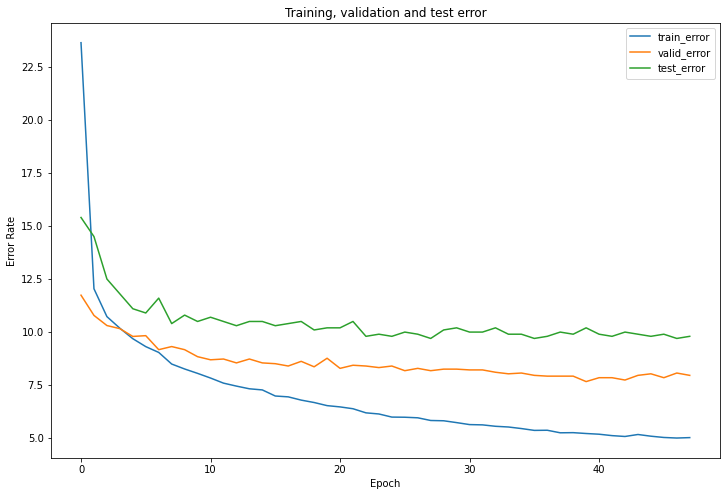

In [ ]:
plt.figure(figsize = (12, 8))
for c in ['train_acc', 'valid_acc', 'test_acc']:
  plt.plot(
      100 * (1-history[c]), label=f'{c[:-4]}_error'
  )
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.title('Training, validation and test error')